In [149]:
import warnings
from causalnex.structure import StructureModel
from causalnex.structure.notears import from_pandas
from IPython.display import Image
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE
from causalnex.network import BayesianNetwork

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import networkx as nx
import pickle

warnings.filterwarnings("ignore")  # silence warnings

sm = StructureModel()

In [74]:
data = pd.read_excel('db_measurements_v2.1.0.xlsx')
non_usable_columns = ['age','gender','index','record_id','building_id',
                    'timestamp','subject_id','ht','wt',
                    'ta_h','ta_m','ta_l','tg_h','tg_m','tg_l',
                    'vel_h','vel_m','vel_l','activity_10',
                    'activity_20','activity_30','activity_60',
                    'blind_curtain', 'fan', 'window', 'door', 'heater',
                     't_out_isd', 'rh_out_isd', 'set','t_mot_isd',
                     'top','tr','tg','air_movement_acceptability',
                     'air_movement_preference','t_out','rh_out','pmv','ppd','pmv_ce','ppd_ce']
data = data.drop(non_usable_columns, axis = 1)
data.head()
#data.dropna()

,season,ta,rh,vel,met,clo,thermal_sensation,thermal_acceptability,thermal_preference,thermal_comfort
0,winter,22.3,61.0,0.03,1.706485,0.95,2.0,acceptable,cooler,4.0
1,winter,23.0,59.0,0.08,1.109215,1.07,2.0,unacceptable,cooler,2.0
2,winter,22.0,61.0,0.04,1.211604,0.88,0.0,acceptable,no change,5.0
3,winter,23.2,58.0,0.03,1.774744,0.59,0.0,acceptable,no change,5.0
4,winter,22.2,62.0,0.15,1.484642,0.83,0.0,acceptable,no change,5.0


In [78]:
data = data.dropna()
data

,season,ta,rh,vel,met,clo,thermal_sensation,thermal_acceptability,thermal_preference,thermal_comfort
0,winter,22.3,61.0,0.03,1.706485,0.95,2.0,acceptable,cooler,4.0
1,winter,23.0,59.0,0.08,1.109215,1.07,2.0,unacceptable,cooler,2.0
2,winter,22.0,61.0,0.04,1.211604,0.88,0.0,acceptable,no change,5.0
3,winter,23.2,58.0,0.03,1.774744,0.59,0.0,acceptable,no change,5.0
4,winter,22.2,62.0,0.15,1.484642,0.83,0.0,acceptable,no change,5.0
...,...,...,...,...,...,...,...,...,...,...
96297,cool/dry,24.5,72.0,0.03,1.200000,0.51,-2.0,acceptable,no change,5.0
96298,cool/dry,24.5,72.0,0.03,1.200000,0.58,-2.0,acceptable,no change,6.0
96299,cool/dry,24.5,72.0,0.03,1.200000,0.51,0.0,acceptable,no change,5.0
96300,cool/dry,24.5,72.0,0.03,1.200000,0.67,-1.0,acceptable,no change,5.0


In [86]:
struct_data = data.rename({'thermal_sensation':'ths','thermal_acceptability':'tha','thermal_preference':'thp','thermal_comfort':'thc'},axis=1)
non_numeric_columns = list(struct_data.select_dtypes(exclude=[np.number]).columns)
print(non_numeric_columns)

['season', 'tha', 'thp']


In [87]:
le = LabelEncoder()

for col in non_numeric_columns:
    struct_data[col] = le.fit_transform(struct_data[col])

struct_data.head()

,season,ta,rh,vel,met,clo,ths,tha,thp,thc
0,3,22.3,61.0,0.03,1.706485,0.95,2.0,0,0,4.0
1,3,23.0,59.0,0.08,1.109215,1.07,2.0,1,0,2.0
2,3,22.0,61.0,0.04,1.211604,0.88,0.0,0,1,5.0
3,3,23.2,58.0,0.03,1.774744,0.59,0.0,0,1,5.0
4,3,22.2,62.0,0.15,1.484642,0.83,0.0,0,1,5.0


In [ ]:
sm = from_pandas(struct_data, w_threshold=0.8) # it was recommended that data should be less than 1000

# https://causalnex.readthedocs.io/en/stable/05_resources/05_faq.html?highlight=1000#what-is-the-recommended-number-of-samples-for-satisfactory-performance

""" 
According to the benchmarking done on synthetic dataset in-house, 
it is highly recommended that at least 1000 samples is used to get a satisfactory performance. 
We also discovered that any further increase than 1000 samples does not help improve the accuracy 
regardless of number of nodes, and it takes a longer time to run.

"""

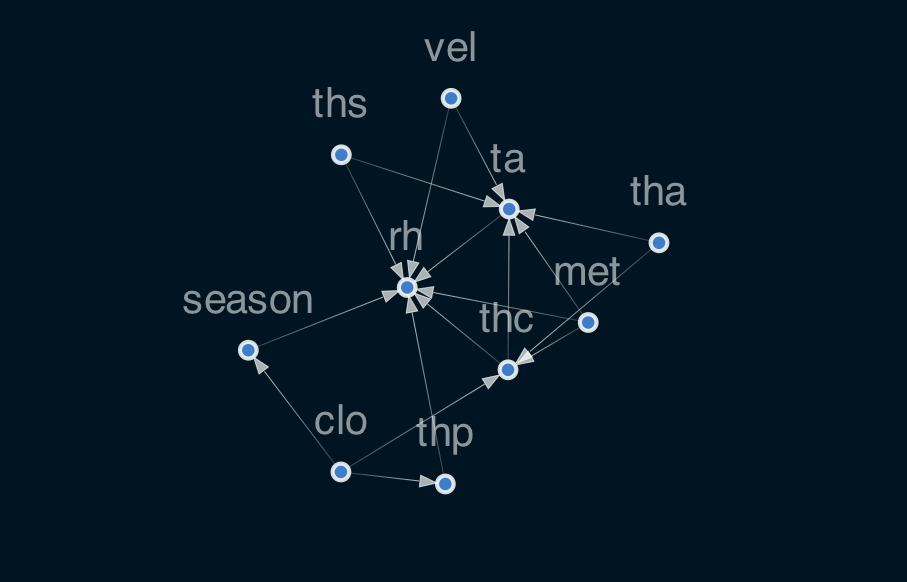

In [94]:
viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)
Image(viz.draw(format='png'))

In [362]:
tabu_edges_domain = [("clo", "season"),("clo","ta"), ("clo","rh"),
                ("vel","rh"),("vel","ta"),
                ("ths","ta"),("ths","rh"),
                ("tha","ta"),("tha","rh"),
                ("met","ta"),("met","rh"),
                ("ta","rh")]

tabu_child_domain = ["season", "tha","building_id"]
tabu_parent_domain = ["thc","thp"]

sm = from_pandas(struct_data, w_threshold=0.5, 
                tabu_edges=tabu_edges_domain, 
                tabu_child_nodes=tabu_child_domain,
                tabu_parent_nodes=tabu_parent_domain) # it was recommended that data should be less than 1000

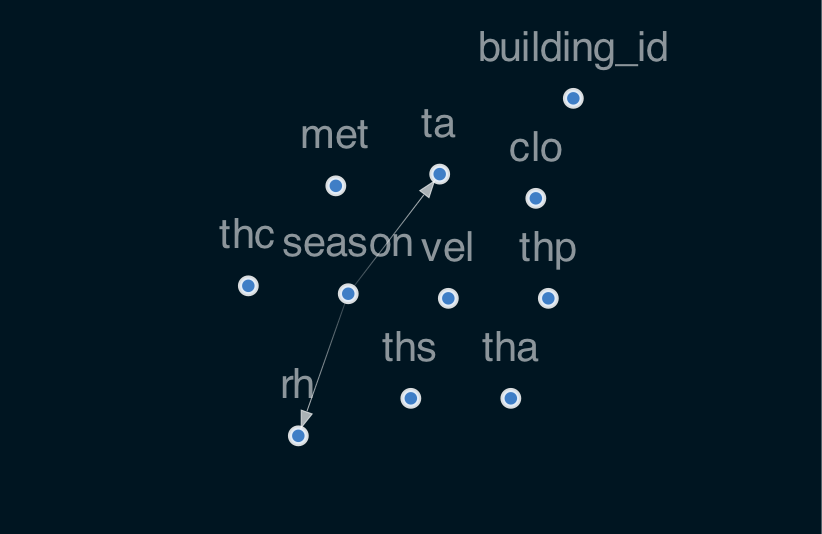

In [363]:
viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)
Image(viz.draw(format='png'))

In [364]:
data = pd.read_csv('db_measurements_v2.1.0.csv')
non_usable_columns = ['age','gender','index','record_id',
                    'timestamp','subject_id','ht','wt',
                    'ta_h','ta_m','ta_l','tg_h','tg_m','tg_l',
                    'vel_h','vel_m','vel_l','activity_10',
                    'activity_20','activity_30','activity_60',
                    'blind_curtain', 'fan', 'window', 'door', 'heater',
                     't_out_isd', 'rh_out_isd', 'set','t_mot_isd',
                     'top','tr','tg','air_movement_acceptability',
                     'air_movement_preference','t_out','rh_out','pmv','ppd','pmv_ce','ppd_ce']
data = data.drop(non_usable_columns, axis = 1)

In [365]:
data = data.dropna()
data

,building_id,season,ta,rh,vel,met,clo,thermal_sensation,thermal_acceptability,thermal_preference,thermal_comfort
0,1,winter,22.3,61.0,0.03,1.706485,0.95,2.0,acceptable,cooler,4.0
1,1,winter,23.0,59.0,0.08,1.109215,1.07,2.0,unacceptable,cooler,2.0
2,1,winter,22.0,61.0,0.04,1.211604,0.88,0.0,acceptable,no change,5.0
3,1,winter,23.2,58.0,0.03,1.774744,0.59,0.0,acceptable,no change,5.0
4,1,winter,22.2,62.0,0.15,1.484642,0.83,0.0,acceptable,no change,5.0
...,...,...,...,...,...,...,...,...,...,...,...
96297,739,cool/dry,24.5,72.0,0.03,1.200000,0.51,-2.0,acceptable,no change,5.0
96298,739,cool/dry,24.5,72.0,0.03,1.200000,0.58,-2.0,acceptable,no change,6.0
96299,739,cool/dry,24.5,72.0,0.03,1.200000,0.51,0.0,acceptable,no change,5.0
96300,739,cool/dry,24.5,72.0,0.03,1.200000,0.67,-1.0,acceptable,no change,5.0


In [366]:
struct_data = data.rename({'thermal_sensation':'ths','thermal_acceptability':'tha','thermal_preference':'thp','thermal_comfort':'thc'},axis=1)
non_numeric_columns = list(struct_data.select_dtypes(exclude=[np.number]).columns)

le = LabelEncoder()

for col in non_numeric_columns:
    struct_data[col] = le.fit_transform(struct_data[col])

struct_data.head()

,building_id,season,ta,rh,vel,met,clo,ths,tha,thp,thc
0,1,3,22.3,61.0,0.03,1.706485,0.95,2.0,0,0,4.0
1,1,3,23.0,59.0,0.08,1.109215,1.07,2.0,1,0,2.0
2,1,3,22.0,61.0,0.04,1.211604,0.88,0.0,0,1,5.0
3,1,3,23.2,58.0,0.03,1.774744,0.59,0.0,0,1,5.0
4,1,3,22.2,62.0,0.15,1.484642,0.83,0.0,0,1,5.0


In [367]:
struct_data_samebd = struct_data[struct_data["building_id"]!=0]
struct_data_samebd = struct_data_samebd.drop(["building_id"], axis = 1)

In [376]:
tabu_edges_domain = [("clo","ta"), ("clo","rh"), ("clo", "season"),
                ("vel","rh"),("vel","ta"),
                ("ths","ta"),("ths","rh"),
                ("tha","ta"),("tha","rh"), ("tha", "ths"), ("tha", "thp"),("tha", "thc"),
                ("met","ta"),("met","rh"),
                ("ta","rh")]

tabu_child_domain = ["season"]
#tabu_child_domain = ["tha"]
tabu_parent_domain = ["thc","thp"]

sm = from_pandas(struct_data_samebd, w_threshold=0.9, 
                tabu_edges=tabu_edges_domain, 
                tabu_child_nodes=tabu_child_domain,
                tabu_parent_nodes=tabu_parent_domain) # it was recommended that data should be less than 1000

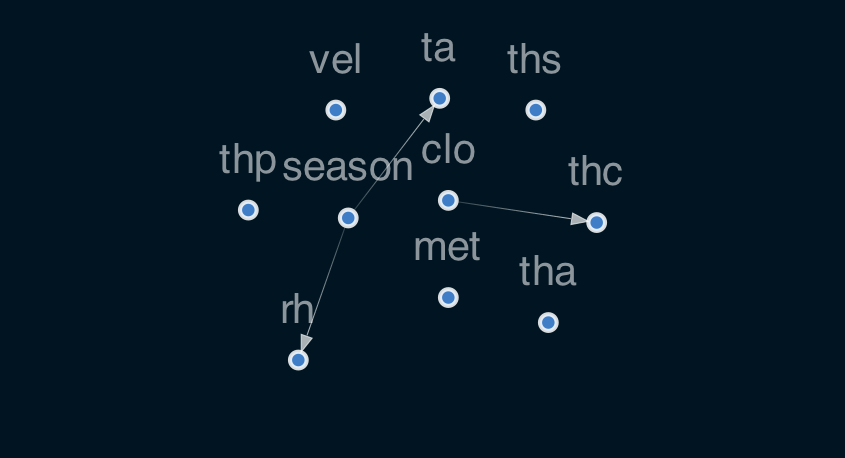

In [377]:
viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)
Image(viz.draw(format='png'))

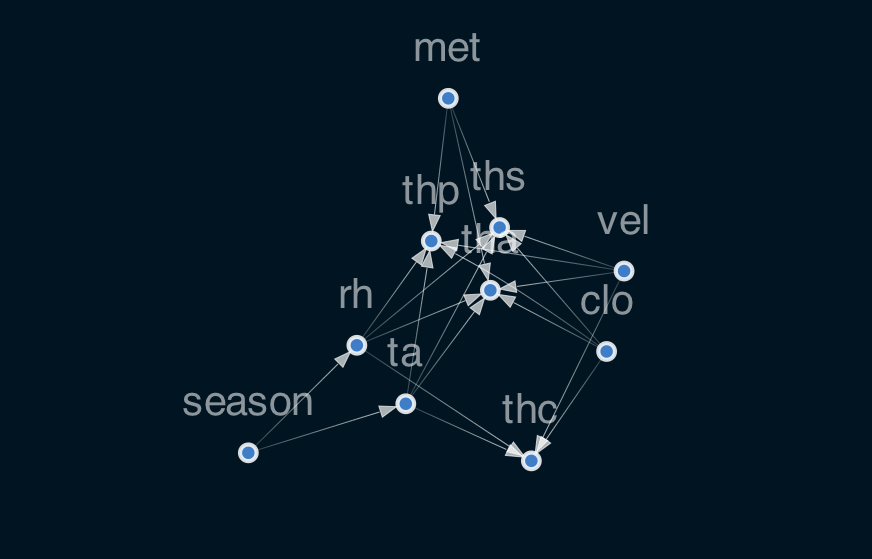

In [299]:
sm.add_edge("ta", "ths")
sm.add_edge("ta", "thc")
sm.add_edge("ta", "ths")
sm.add_edge("ta", "thp")
sm.add_edge("ta", "tha")

sm.add_edge("rh", "ths")
sm.add_edge("rh", "thc")
sm.add_edge("rh", "thp")
sm.add_edge("rh", "tha")

sm.add_edge("vel", "ths")
sm.add_edge("vel", "thc")
sm.add_edge("vel", "thp")
sm.add_edge("vel", "tha")

sm.add_edge("met", "ths")
#sm.add_edge("met", "thc")
sm.add_edge("met", "thp")
sm.add_edge("met", "tha")
sm.add_edge("clo", "ths")
sm.add_edge("clo", "thp")
sm.add_edge("clo", "tha")

viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK,
)
Image(viz.draw(format='png'))

In [300]:
bn = BayesianNetwork(sm)

In [301]:
discretised_data = struct_data_samebd.copy()

In [302]:
struct_data_samebd

,season,ta,rh,vel,met,clo,ths,tha,thp,thc
0,3,22.3,61.0,0.03,1.706485,0.95,2.0,0,0,4.0
1,3,23.0,59.0,0.08,1.109215,1.07,2.0,1,0,2.0
2,3,22.0,61.0,0.04,1.211604,0.88,0.0,0,1,5.0
3,3,23.2,58.0,0.03,1.774744,0.59,0.0,0,1,5.0
4,3,22.2,62.0,0.15,1.484642,0.83,0.0,0,1,5.0
...,...,...,...,...,...,...,...,...,...,...
96297,0,24.5,72.0,0.03,1.200000,0.51,-2.0,0,1,5.0
96298,0,24.5,72.0,0.03,1.200000,0.58,-2.0,0,1,6.0
96299,0,24.5,72.0,0.03,1.200000,0.51,0.0,0,1,5.0
96300,0,24.5,72.0,0.03,1.200000,0.67,-1.0,0,1,5.0


In [303]:
from causalnex.discretiser import Discretiser

discretised_data["ta"] = Discretiser(method="fixed",
                          numeric_split_points=[1, 10]).transform(discretised_data["ta"].values)
discretised_data["rh"] = Discretiser(method="fixed",
                          numeric_split_points=[10]).transform(discretised_data["rh"].values)
discretised_data["vel"] = Discretiser(method="fixed",
                          numeric_split_points=[10]).transform(discretised_data["vel"].values)
discretised_data["met"] = Discretiser(method="fixed",
                          numeric_split_points=[10]).transform(discretised_data["met"].values)
discretised_data["clo"] = Discretiser(method="fixed",
                          numeric_split_points=[10]).transform(discretised_data["clo"].values)

In [330]:
seasons_map = {0: "cool/dry", 1: "hot/wet", 2: "summer", 3: "winter"}
tha_map = {0: " acceptable", 1: "unacceptable"}
thp_map = {0: "cooler", 1: "no change", 2: "warmer"}

discretised_data["season"] = discretised_data["season"].map(seasons_map)
discretised_data["tha"] = discretised_data["tha"].map(tha_map)
discretised_data["thp"] = discretised_data["thp"].map(thp_map)

In [341]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(discretised_data, train_size=0.7, test_size=0.3, random_state=7)

In [342]:
bn = bn.fit_node_states(discretised_data)

In [343]:
bn = bn.fit_cpds(train, method="BayesianEstimator", bayes_prior="K2")

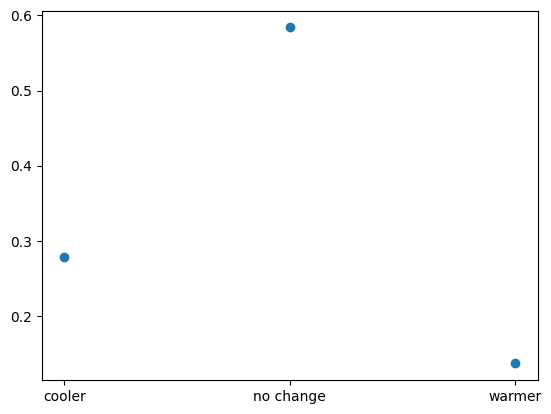

In [344]:
import matplotlib.pyplot as plt 

x = bn.cpds["thp"].index
y = bn.cpds["thp"]
plt.scatter(x, y)

In [345]:
discretised_data.loc[32, discretised_data.columns != 'thp']

season         winter
ta                  2
rh                  1
vel                 0
met                 0
clo                 0
ths               0.0
tha        acceptable
thc               4.0
Name: 32, dtype: object

In [351]:
predictions = bn.predict(discretised_data, "thp")
print(f"The prediction is '{predictions.loc[12, 'thp_prediction']}'")
print(f"The ground truth is '{discretised_data.loc[12, 'thp']}'")

The prediction is 'no change'
The ground truth is 'no change'


In [354]:
from causalnex.evaluation import classification_report

classification_report(bn, test, "thp")

{'thp_cooler': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 1218},
 'thp_no change': {'precision': 0.5664223545579478,
  'recall': 1.0,
  'f1-score': 0.7232051469513087,
  'support': 2473},
 'thp_warmer': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 675},
 'accuracy': 0.5664223545579478,
 'macro avg': {'precision': 0.1888074515193159,
  'recall': 0.3333333333333333,
  'f1-score': 0.2410683823171029,
  'support': 4366},
 'weighted avg': {'precision': 0.32083428374296946,
  'recall': 0.5664223545579478,
  'f1-score': 0.4096395621645869,
  'support': 4366}}

In [352]:
from causalnex.evaluation import roc_auc
roc, auc = roc_auc(bn, test, "thp")
print(auc)

0.7059092991296381


In [355]:
bn = bn.fit_cpds(discretised_data, method="BayesianEstimator", bayes_prior="K2")

In [357]:
from causalnex.inference import InferenceEngine

ie = InferenceEngine(bn)
marginals = ie.query()
marginals["thp"]

{'cooler': 0.27892278098378664,
 'no change': 0.5786617202528165,
 'warmer': 0.1424154987633965}

In [358]:
import numpy as np

labels, counts = np.unique(discretised_data["thp"], return_counts=True)
list(zip(labels, counts))

[('cooler', 4059), ('no change', 8422), ('warmer', 2072)]